In [1]:
import torch
torch.__version__

'2.1.1+cu118'

In [2]:
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

In [3]:
X, y

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        ...,
        [-0.13690036, -0.81001183],
        [ 0.67036156, -0.76750154],
        [ 0.28105665,  0.96382443]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 

In [4]:
import pandas as pd
circles = pd.DataFrame(
    {
        "x1": X[:,0],
        "x2": X[:,1],
        "label": y
    }
)

In [5]:
circles

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [6]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

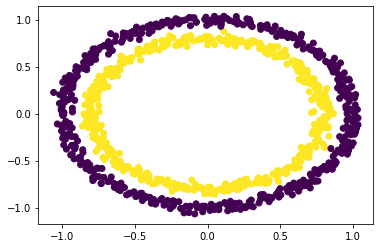

In [7]:
import matplotlib.pyplot as plt
plt.scatter(
    x = X[:,0],
    y = X[:,1],
    c = y
)

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# converting it into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [13]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
untrained_preds = model_0(X_test.to(device))

In [16]:
untrained_preds[:10], y_test[:10]

(tensor([[0.3323],
         [0.1708],
         [0.8439],
         [0.1870],
         [0.9839],
         [0.8842],
         [0.3185],
         [0.4859],
         [0.8372],
         [0.1615]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [18]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_true))*100
    return acc

In [19]:
# training loop
torch.manual_seed(42)

num_epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model_0 = model_0.to(device)

for epoch in range(num_epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # logits --> pred probs --> pred labels

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    
    if epoch % 10 == 0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%, | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")

epoch: 0 | Loss: 0.75945, Accuracy: 50.00%, | Test loss: 0.73471, Test accuracy: 50.00%
epoch: 10 | Loss: 0.72005, Accuracy: 53.12%, | Test loss: 0.70586, Test accuracy: 55.50%
epoch: 20 | Loss: 0.70591, Accuracy: 54.00%, | Test loss: 0.69661, Test accuracy: 57.50%
epoch: 30 | Loss: 0.70039, Accuracy: 52.12%, | Test loss: 0.69370, Test accuracy: 51.00%
epoch: 40 | Loss: 0.69801, Accuracy: 51.50%, | Test loss: 0.69286, Test accuracy: 50.00%
epoch: 50 | Loss: 0.69683, Accuracy: 50.75%, | Test loss: 0.69268, Test accuracy: 51.00%
epoch: 60 | Loss: 0.69613, Accuracy: 51.00%, | Test loss: 0.69270, Test accuracy: 50.00%
epoch: 70 | Loss: 0.69565, Accuracy: 50.50%, | Test loss: 0.69275, Test accuracy: 48.50%
epoch: 80 | Loss: 0.69529, Accuracy: 49.88%, | Test loss: 0.69282, Test accuracy: 50.00%
epoch: 90 | Loss: 0.69500, Accuracy: 50.00%, | Test loss: 0.69287, Test accuracy: 50.50%


In [32]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

NameError: name 'X_train' is not defined

In [21]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

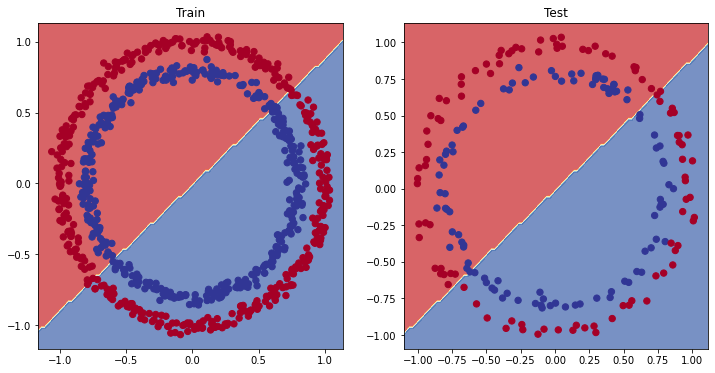

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [23]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr = 0.1)

In [25]:
torch.manual_seed(42)

num_epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model_1 = model_1.to(device)

for epoch in range(num_epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")

epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test accuracy: 51.00%
epoch: 10 | Loss: 0.69369, Accuracy: 50.25% | Test loss: 0.69270, Test accuracy: 50.00%


epoch: 20 | Loss: 0.69351, Accuracy: 50.12% | Test loss: 0.69283, Test accuracy: 49.50%
epoch: 30 | Loss: 0.69339, Accuracy: 50.50% | Test loss: 0.69297, Test accuracy: 48.00%
epoch: 40 | Loss: 0.69329, Accuracy: 50.38% | Test loss: 0.69310, Test accuracy: 49.00%
epoch: 50 | Loss: 0.69322, Accuracy: 49.88% | Test loss: 0.69324, Test accuracy: 50.00%
epoch: 60 | Loss: 0.69317, Accuracy: 49.38% | Test loss: 0.69336, Test accuracy: 51.50%
epoch: 70 | Loss: 0.69312, Accuracy: 49.38% | Test loss: 0.69348, Test accuracy: 50.50%
epoch: 80 | Loss: 0.69309, Accuracy: 50.12% | Test loss: 0.69359, Test accuracy: 50.00%
epoch: 90 | Loss: 0.69307, Accuracy: 50.50% | Test loss: 0.69370, Test accuracy: 48.50%
epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test accuracy: 48.00%
epoch: 110 | Loss: 0.69303, Accuracy: 50.88% | Test loss: 0.69388, Test accuracy: 46.50%
epoch: 120 | Loss: 0.69302, Accuracy: 50.75% | Test loss: 0.69396, Test accuracy: 46.50%
epoch: 130 | Loss: 0.69301, A

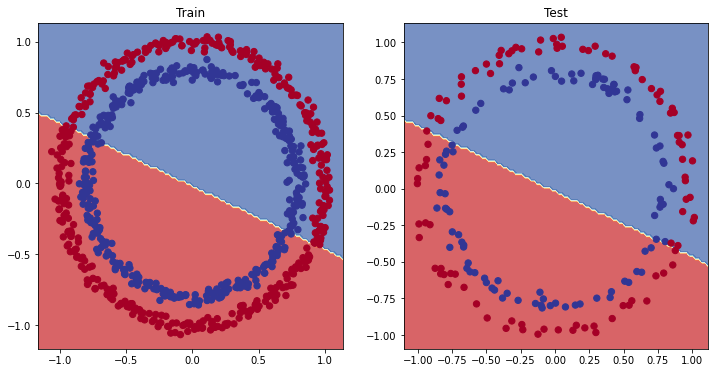

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Introducing Non-linearity using ReLU

In [27]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

In [28]:
model_3 = CircleModelV3().to(device)
print(model_3)

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [29]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [30]:
torch.manual_seed(42)
num_epochs = 1000

for epoch in range(num_epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")
    

epoch: 0 | Loss: 0.69833, Accuracy: 50.00% | Test loss: 0.69863, Test accuracy: 49.00%
epoch: 10 | Loss: 0.69697, Accuracy: 49.62% | Test loss: 0.69757, Test accuracy: 49.50%
epoch: 20 | Loss: 0.69618, Accuracy: 49.62% | Test loss: 0.69700, Test accuracy: 49.50%


epoch: 30 | Loss: 0.69558, Accuracy: 49.38% | Test loss: 0.69654, Test accuracy: 48.50%
epoch: 40 | Loss: 0.69498, Accuracy: 49.75% | Test loss: 0.69609, Test accuracy: 48.00%
epoch: 50 | Loss: 0.69453, Accuracy: 50.25% | Test loss: 0.69578, Test accuracy: 48.50%
epoch: 60 | Loss: 0.69418, Accuracy: 49.62% | Test loss: 0.69550, Test accuracy: 47.50%
epoch: 70 | Loss: 0.69386, Accuracy: 50.25% | Test loss: 0.69519, Test accuracy: 47.00%
epoch: 80 | Loss: 0.69354, Accuracy: 50.12% | Test loss: 0.69487, Test accuracy: 48.00%
epoch: 90 | Loss: 0.69323, Accuracy: 50.50% | Test loss: 0.69454, Test accuracy: 47.50%
epoch: 100 | Loss: 0.69289, Accuracy: 50.88% | Test loss: 0.69411, Test accuracy: 47.00%
epoch: 110 | Loss: 0.69232, Accuracy: 50.88% | Test loss: 0.69352, Test accuracy: 49.00%
epoch: 120 | Loss: 0.69202, Accuracy: 51.38% | Test loss: 0.69327, Test accuracy: 47.50%
epoch: 130 | Loss: 0.69178, Accuracy: 54.00% | Test loss: 0.69304, Test accuracy: 50.00%
epoch: 140 | Loss: 0.69153, 

In [25]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


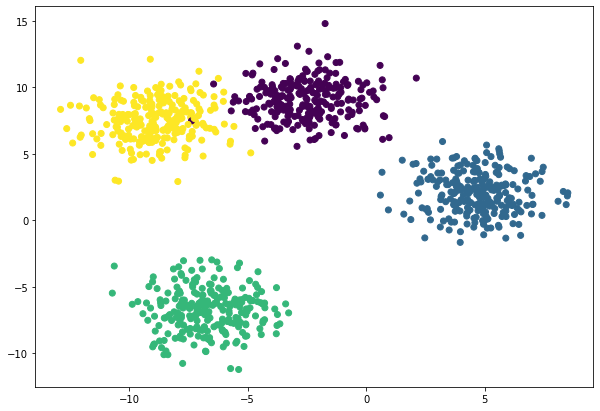

In [26]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

print(X_blob_train.shape, X_blob_test.shape, y_blob_train.shape, y_blob_test.shape)

plt.figure(figsize=(10,7))
plt.scatter(x=X_blob[:, 0], y=X_blob[:,1], c=y_blob)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [29]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [30]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_true))*100
    return acc

In [31]:
# training loop
torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train).squeeze()
    # print(y_logits, y_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test).squeeze()
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)

    if epoch % 10 == 0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")

epoch: 0 | Loss: 1.04324, Accuracy: 65.50% | Test loss: 0.57861, Test accuracy: 95.50%
epoch: 10 | Loss: 0.14398, Accuracy: 99.12% | Test loss: 0.13037, Test accuracy: 99.00%
epoch: 20 | Loss: 0.08062, Accuracy: 99.12% | Test loss: 0.07216, Test accuracy: 99.50%
epoch: 30 | Loss: 0.05924, Accuracy: 99.12% | Test loss: 0.05133, Test accuracy: 99.50%
epoch: 40 | Loss: 0.04892, Accuracy: 99.00% | Test loss: 0.04098, Test accuracy: 99.50%
epoch: 50 | Loss: 0.04295, Accuracy: 99.00% | Test loss: 0.03486, Test accuracy: 99.50%
epoch: 60 | Loss: 0.03910, Accuracy: 99.00% | Test loss: 0.03083, Test accuracy: 99.50%
epoch: 70 | Loss: 0.03643, Accuracy: 99.00% | Test loss: 0.02799, Test accuracy: 99.50%
epoch: 80 | Loss: 0.03448, Accuracy: 99.00% | Test loss: 0.02587, Test accuracy: 99.50%
epoch: 90 | Loss: 0.03300, Accuracy: 99.12% | Test loss: 0.02423, Test accuracy: 99.50%


In [33]:
def plot_predictions(train_data=X_blob_train, 
                     train_labels=y_blob_train, 
                     test_data=X_blob_test, 
                     test_labels=y_blob_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

In [34]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

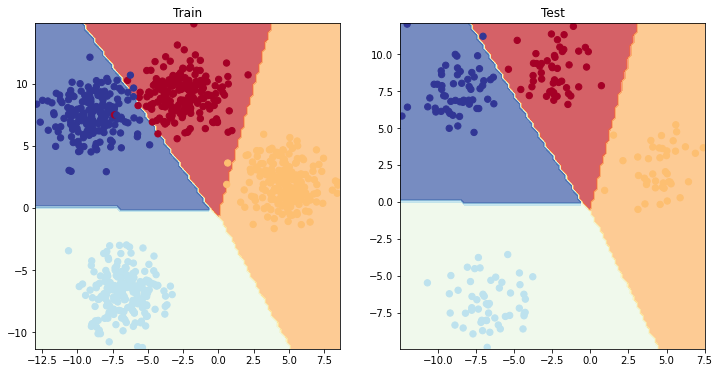

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)